## Alexnet

In [ ]:
import torch

device=torch.device('cuda') #gpu
torch.cuda.is_available()

True

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

fashion_mnist_transform=transforms.Compose([
    transforms.ToTensor(), #tensor형으로 변경
    transforms.Resize(224)  #크기 변경(1X28x28 -> 1X224X224)
])

download_root='./' #현재위치폴더에 다운로드

train_dataset=FashionMNIST(download_root, transform=fashion_mnist_transform, train=True, download=True)
test_dataset=FashionMNIST(download_root, transform=fashion_mnist_transform, train=False, download=True)

In [ ]:
from torch.utils.data import DataLoader

batch_size=64

train_loader=DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

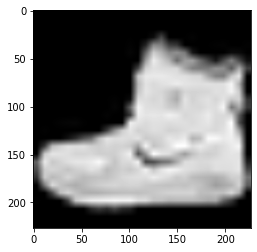

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[0][0][0].numpy(), cmap='gray')

In [ ]:
from torch import nn

model=nn.Sequential(
    #convolution
    #fully connected
    #Relu
)
class AlexNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.CNN=nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=48, kernel_size=11, stride=4, padding=0),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5,k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(in_channels=48, out_channels=128, kernel_size=5, stride=1, padding=2),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5,k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(in_channels=128, out_channels=192, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5,k=2),

        nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5,k=2),

        nn.Conv2d(in_channels=192, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5,k=2),
        nn.MaxPool2d(kernel_size=3, stride=2)
    )
    self.FC=nn.Sequential(
        nn.Linear(128*6*6,2048),
        nn.ReLU(True),
        nn.Dropout(0.5), #절반의 model은 날리고 학습에 사용
        
        nn.Linear(2048,2048),
        nn.ReLU(True),
        nn.Dropout(0.5),

        nn.Linear(2048,10),
        nn.Softmax()
    )
    #bbbb

  def forward(self, inp):
    cnn_res=self.CNN(inp)
    #flatten 128*6*6 -> 00000
    flatten=torch.flatten(cnn_res, 1)
    fc_res=self.FC(flatten)
    return fc_res

In [ ]:
from torch import optim

def train(model, epochs):

  #optimizer 설정(가중치 학습할때 어느정도 반영할지, train model의 parameter 모두 집어넣은 것)
  optimizer=optim.Adam(model.parameters(), lr=0.0001)
  #loss function
  criterion=nn.CrossEntropyLoss()  #classification 분류 

  for epoch in range(epochs):
    model.train()  #model을 train 상태로
    train_accuracy=0.0

    for batch_ind, samples in enumerate(train_loader):
      x_t,y_t=samples #x는 입력 y는 출력
      #device로 x_t, y_t 보냄
      x_t,y_t=x_t.to(device),y_t.to(device)
      
      # x_t 넣어서 predicted 
      pred=model(x_t)
      
      # predicted랑 y_t 비교
      # 둘의 차이 = loss 계산
      loss=criterion(pred, y_t)

      # loss값을 가지고 back-propagation weight를 업데이트
      # optimizer가 해줍니다
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

   # accuracy test for train dataset
    model.eval()  #model을 평가상태로
    correct=0
    for xx,yy in train_loader:
      data, target=xx.to(device), yy.to(device)
      pred=model(data) #pred [0,0,0.1,0.2,0.1,...0] 합 1
      _, predicted=torch.max(pred,1)
      correct+=predicted.eq(target.data).sum()

    print("train accuracy:",(100.*correct/len(train_loader.dataset)).item())

In [ ]:
alexnet=AlexNet()
alexnet.to(device)
train(alexnet,10)

train accuracy: 72.61000061035156
train accuracy: 77.0616683959961
train accuracy: 79.1500015258789
train accuracy: 80.08833312988281
train accuracy: 85.53833770751953
train accuracy: 87.4183349609375
train accuracy: 88.54666900634766
train accuracy: 88.66500091552734
train accuracy: 88.71833801269531
train accuracy: 90.05999755859375


## train(mode,3) -> 알아서 학습

In [ ]:
def get_n_params(model):
  pp=0
  for p in list(model.parameters()):
    nn=1
    for s in list(p.size()):
      nn=nn*s
    pp+=nn
  return pp

In [ ]:
get_n_params(alexnet)

14590314

In [ ]:
alexnet.eval()
correct=0
for xx,yy in test_loader:
  data, target=xx.to(device), yy.to(device)
  pred=alexnet(data) #pred [0,0,0.1,0.2,0.1,...0] 합 1
  _, predicted=torch.max(pred,1)
  correct+=predicted.eq(target.data).sum()

print("train accuracy:",(100.*correct/len(train_loader.dataset)).item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train accuracy: 14.851666450500488


In [ ]:
alexnet

AlexNet(
  (CNN): Sequential(
    (0): Conv2d(1, 48, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (11): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (14): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): LocalResponseNorm(5, alpha=0.0001, beta